In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from MIL_functions import data_analysis,molecule_analysis
from rdkit import Chem
from rdkit.Chem import Draw
import copy
import operator
from rdkit.Chem import MACCSkeys,Draw
from rdkit import DataStructs

from IPython import display as ICD
## done to hide an unneccesary error
pd.options.mode.chained_assignment = None  # default='warn'

c:\Users\Sam\anaconda3\envs\rdkit\Lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [18]:
def label_results(true,pred):
    if true == pred:
        if pred == 1:
            return 'TP'
        else:
            return 'TN'
    else:
        if pred ==1:
            return 'FP'
        else:
            return 'FN'
        
def get_metrics(l):
    tp = len([i for i in l if i=="TP"])
    tn = len([i for i in l if i=="TN"])
    fp = len([i for i in l if i=="FP"])
    fn = len([i for i in l if i=="FN"])
    if tp+fn>0:
        sens = tp/(tp+fn) 
    else:
        sens = 0
    if tn+fp>0:
        spec = tn/(tn+fp)
    else:
        spec = 0
    bal_acc = (sens+spec)/2
    acc = (tp+tn)/(tp+tn+fp+fn)
    return sens,spec,acc,bal_acc

def molecule_group_analysis(data,function):
    molecule_group = data[data['Molecule'].apply(lambda x: function(x))]
    if molecule_group.empty:
        print('Molecule group not found')
        return False
    else:
        return molecule_group

def polyaromatic_check(m):
    ri = m.GetRingInfo()
    aro_rings = []
    for ring_bonds in ri.BondRings():
        if all([m.GetBondWithIdx(b).GetIsAromatic() for b in ring_bonds]):
            aro_rings.append(ring_bonds)

    for aro_ring_bonds in aro_rings:
        ## an assumptions i'm fairly sure is true always: 
        # if there is a ring that shares 2 bonds with other aromatic rings th emolecules has >= 3 fused rings 
        # .: if there is a ring with two bonds that belong to other aromatic rings then that is a >=3 fused ring molecule
        shared_bonds = 0
        for bond in aro_ring_bonds:
            if bond in [b for bs in aro_rings for b in bs if bs!=aro_ring_bonds]:
                shared_bonds+=1
        if shared_bonds>=2:
            return True
    return False


def PAB_check(m):
    benzene = Chem.MolFromSmarts('[c]1[c][c][c][c][c]1')
    phenol = Chem.MolFromSmarts('[c]1(-[OH1])[c][c][c][c][c]1')
    aniline = Chem.MolFromSmarts('[c]1(-[NH2])[c][c][c][c][c]1')
    benzamide = Chem.MolFromSmarts('[c]1(-C(=[O])-[NH2])[c][c][c][c][c]1')
    if len(m.GetSubstructMatches(benzene)) == 1:
        for group in [phenol,aniline,benzamide]:
            if  m.HasSubstructMatch(group):
                    return True
    return False


def non_aro_halide(m):  
    if not any([a.GetIsAromatic() for a in m.GetAtoms()]):
        for halide in [a for a in m.GetAtoms() if a.GetAtomicNum() in [17,35,53]]:
            if len(halide.GetNeighbors())==1 and halide.GetNeighbors()[0].GetAtomicNum()==6:
                bonds = [b for b in m.GetBonds()]
                single_bonds = [b for b in m.GetBonds() if b.GetBondTypeAsDouble()==1.0]
                double_bonds = [b for b in m.GetBonds() if b.GetBondTypeAsDouble()==2.0]
                if len(bonds)==len(single_bonds) or (len(double_bonds)==1 and len(bonds)-1==len(single_bonds)):
                    return True
    return False

def azide_check(m):
    azide = Chem.MolFromSmarts('[NX2]=[N+1]=[N-1]')
    if m.HasSubstructMatch(azide):
        return True
    return False

def octahydrobenzo_f_benzoquinolines_check(m):
    group = Chem.MolFromSmiles('*c1cccc2c1CCC3C2CC(*)CN3*')
    if m.HasSubstructMatch(group):
        return True
    return False

def aromatic_nitro_check(m):
    aro_nitro = Chem.MolFromSmarts('[c]1([N](=[O])-O)[c][c][c][c][c]1')
    if m.HasSubstructMatch(aro_nitro):
        return True
    return False

def four_benzyl_piperidines_check(given_mol):
    mol = given_mol
    group = Chem.MolFromSmiles('*N2CCC(Cc1ccccc1)CC2')
    if mol.HasSubstructMatch(group):
        return True
    return False

def quinoline_check(given_mol):
    failed = False
    mol = given_mol
    quinoline = Chem.MolFromSmiles('c2ccc1ncccc1c2')
    if mol.HasSubstructMatch(quinoline): 
        ###### This checks that no additional aromatic groups are attached to the quinoline (extra fused rings)
        base_structures = mol.GetSubstructMatches(quinoline)
        for base_structure in base_structures:
            for idx in base_structure:
                base = mol.GetAtomWithIdx(idx)
                neighbors = [neighbor for neighbor in base.GetNeighbors() if neighbor.GetIdx() not in base_structure]
                if any(neighbor.GetIsAromatic() for neighbor in neighbors):
                    failed = True
            if not failed:
                return True
    return False

            # Note: simple aromatic check was used since the complex version found more molecules than that in the paper using a subset of its data

def furan_wo_nitro_check(given_mol):
    def check_mol_nitrogen(mole,nitrogen_index,furan_atom_index):
        edited_mol = Chem.RWMol(mole)
        nitro = Chem.MolFromSmiles('O=NO')
        furan_N_bond_idx = edited_mol.GetBondBetweenAtoms(nitrogen_index,furan_atom_index).GetIdx()
        frags = Chem.FragmentOnBonds(edited_mol, [furan_N_bond_idx])
        # try:
        global f
        if len(Chem.GetMolFrags(frags, asMols=False)) >1:
            for frag in Chem.GetMolFrags(frags, asMols=True):
                if frag.HasSubstructMatch(nitro):
                    if any(all(True for neighbor in atom.GetNeighbors() if neighbor.GetAtomicNum()==7 and len(atom.GetNeighbors())==1) for atom in frag.GetAtoms() if atom.GetAtomicNum()==0):
                        if frag.GetNumAtoms()==4:
                            return False
            return True
    def exclude_furan_fused_rings(mole):
        furan = Chem.MolFromSmiles('c1ccoc1')
        if mole.HasSubstructMatch(furan):
            base_structures = mole.GetSubstructMatches(furan)
            for base_structure in base_structures:
                for idx in base_structure:
                    base = mole.GetAtomWithIdx(idx)
                    neighbors = [neighbor for neighbor in base.GetNeighbors() if neighbor.GetIdx() not in base_structure]
                    if neighbors:
                        if not any(mole.GetBondBetweenAtoms(idx,neighbor.GetIdx()).IsInRing() for neighbor in neighbors):
                            return True
        return False
    
    mol = given_mol
    furan = Chem.MolFromSmiles('c1ccoc1')
        
    if exclude_furan_fused_rings(mol):
        if mol.HasSubstructMatch(furan):
            base_structures = mol.GetSubstructMatches(furan)
            for base_structure in base_structures:
                failed = False
                for idx in base_structure:
                    base = mol.GetAtomWithIdx(idx)
                    neighbors = [neighbor for neighbor in base.GetNeighbors() if neighbor.GetIdx() not in base_structure]
                    if neighbors:
                        N_neighbor = [neighbor for neighbor in neighbors if neighbor.GetAtomicNum()==7]
                        if len(N_neighbor):
                            N_neighbor = N_neighbor[0]
                            if not check_mol_nitrogen(mole=mol,nitrogen_index = N_neighbor.GetIdx(),furan_atom_index=idx):
                                    failed = True

                if not failed:
                    return True
                    
    return False

In [6]:
data = pd.read_csv('model_results/exported_results/Hansen/NSK_polynomial_Morgan.csv')
data['result'] = data.apply(lambda row: label_results(true=row['true label'], pred=row['predicted labal']),axis=1)
data['Molecule'] = data['smiles'].apply(lambda x: Chem.MolFromSmiles(x))
acc,sens,spec,bal_acc = get_metrics(data['result'])
print('Accuracy:',round(acc,3),'    Sensitivity:',round(sens,3),'    Specificity:',round(spec,3),'    Balanced accuracy:',round(bal_acc,3))

Accuracy: 0.788     Sensitivity: 0.766     Specificity: 0.778     Balanced accuracy: 0.777


## Checking Hillebrech identified poor predictors

In [19]:
tests = {"polyaromatic":polyaromatic_check,"PABs":PAB_check,"alkene/alkyl halides":non_aro_halide,
        "azides":azide_check,"octahydrobenzo f benzoquinolines":octahydrobenzo_f_benzoquinolines_check,
        "aromatic nitro":aromatic_nitro_check,"4-benzyl pipididines":four_benzyl_piperidines_check,
        "quinolines":quinoline_check,"furans without nitro":furan_wo_nitro_check}

for test in tests:
    print('*'*(len(test)+8));print("*** "+test+(" ***"));print('*'*(len(test)+8))
    group = molecule_group_analysis(data=data, function=tests[test])
    if type(group)!=bool:
        pos = sum(group['true label']==1)
        neg = sum(group['true label']==0)
        sens,spec,acc,bal_acc = get_metrics(group['result'].to_list())
        print('Ames +:',pos,'     Ames-:',neg,'     count:',pos+neg,'     percent positive:',str(round(pos/(pos+neg)*100,2))+'%')
        print('Sensitivity:',round(sens,3),'     Specificity:',round(spec,3),'     Accuracy:',round(acc,3),'     Balanced Accuracy:',round(bal_acc,3))
    print()
    print()

********************
*** polyaromatic ***
********************
Ames +: 825      Ames-: 141      count: 966      percent positive: 85.4%
Sensitivity: 0.899      Specificity: 0.369      Accuracy: 0.822      Balanced Accuracy: 0.634


************
*** PABs ***
************
Ames +: 189      Ames-: 249      count: 438      percent positive: 43.15%
Sensitivity: 0.762      Specificity: 0.767      Accuracy: 0.765      Balanced Accuracy: 0.764


****************************
*** alkene/alkyl halides ***
****************************
Ames +: 147      Ames-: 91      count: 238      percent positive: 61.76%
Sensitivity: 0.755      Specificity: 0.604      Accuracy: 0.697      Balanced Accuracy: 0.68


**************
*** azides ***
**************
Ames +: 61      Ames-: 2      count: 63      percent positive: 96.83%
Sensitivity: 0.951      Specificity: 0.0      Accuracy: 0.921      Balanced Accuracy: 0.475


****************************************
*** octahydrobenzo f benzoquinolines ***
*************

## Analyzing the results to look into possible poor predictive classes

In [8]:
data['MACCS'] = data['Molecule'].apply(lambda x: MACCSkeys.GenMACCSKeys(x))

sims = []
thresh = 0.75

found = []
for mc,smi in zip(data['MACCS'],data['smiles']):
    if not smi in found:
        similar = data[data['MACCS'].apply(lambda x: DataStructs.TanimotoSimilarity(mc,x)>thresh)]
        if len(similar) > 10:
            pos = sum(similar['true label']==1)
            neg = sum(similar['true label']==0)
            sens,spec,acc,bal_acc = get_metrics(similar['result'])
            if (spec<0.75 and neg>=10) or (sens<0.75 and pos>=10):
                if len(similar)>10:

                    found += similar['smiles'].to_list()
                    sims += [similar]

print(len(sims))

56


#### use this code to look over the similar groups one at a time by changing the variable "i"

63 14
[0.968, 0.357, 0.857, 0.663]


c:\Users\Sam\anaconda3\envs\rdkit\Lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


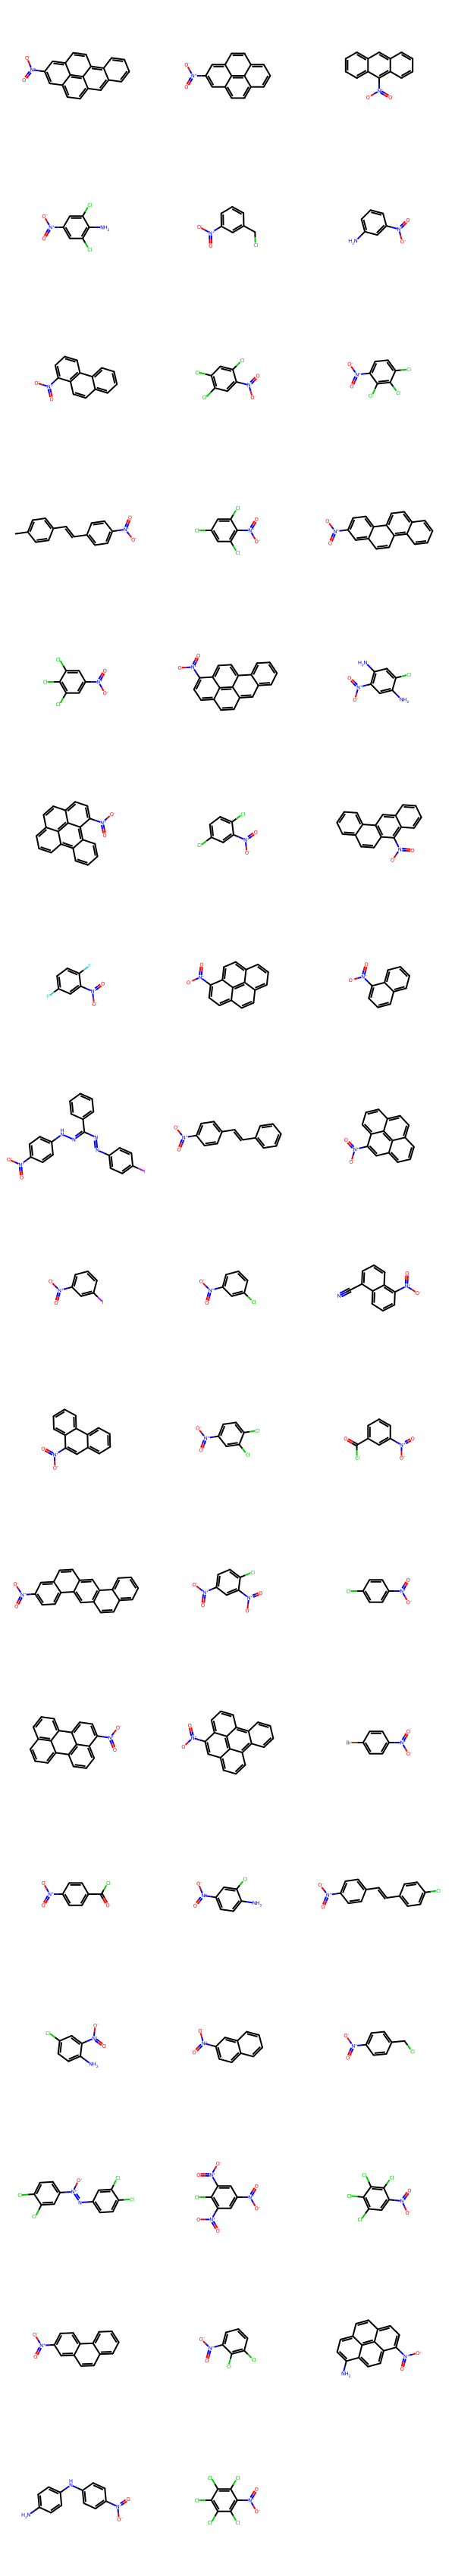

In [20]:
i = 55
pos = sum(sims[i]['true label']==1)
neg = sum(sims[i]['true label']==0)
print(pos,neg)
print([round(i,3) for i in get_metrics(sims[i]['result'])])
Draw.MolsToGridImage(sims[i]['Molecule'])

## Found poor predictors as found via code

#### please note other poor predictors were also found using Datawarrior and are not present here for that reason

In [21]:
def quinoline_check(given_mol):
    failed = False
    mol = given_mol
    quinoline = Chem.MolFromSmiles('c2ccc1ncccc1c2')
    if mol.HasSubstructMatch(quinoline): 
        ###### This checks that no additional aromatic groups are attached to the quinoline (extra fused rings)
        base_structures = mol.GetSubstructMatches(quinoline)
        for base_structure in base_structures:
            for idx in base_structure:
                base = mol.GetAtomWithIdx(idx)
                neighbors = [neighbor for neighbor in base.GetNeighbors() if neighbor.GetIdx() not in base_structure]
                if any(neighbor.GetIsAromatic() for neighbor in neighbors):
                    failed = True
            if not failed:
                return True
    return False


def test1(m):
    m2 = copy.deepcopy(m)
    Chem.Kekulize(m2)
    test_struc = Chem.MolFromSmarts('[#6]1(-[OH1])-[#6](-[OH1])-[#6]=[#6]-[#6]=[#6]-1')
    if m2.HasSubstructMatch(test_struc):
        return True
    return False

def test2(m):
    m2 = copy.deepcopy(m)
    Chem.Kekulize(m2)
    test_struc = Chem.MolFromSmarts('[#6]1-[#6]2-[#6](-[O]-2)-[#6](-[OH])-[#6](-[OH])-[#6]=1')
    if m2.HasSubstructMatch(test_struc):
        return True
    return False

def has_halogen(m):
    halogens = [a for a in m.GetAtoms() if a.GetAtomicNum() in [9,17,35,53,85,117]]
    if len(halogens)>0:
        return True
    return False

def has_aro_halogen(m):
    halogens = [a for a in m.GetAtoms() if a.GetAtomicNum() in [9,17,35,53,85,117]]
    aro_halo = [h for h in halogens if any([n.GetIsAromatic() for n in h.GetNeighbors()])]
    if len(aro_halo)>0:
        return True
    return False

def dihydroxyl_ring(m):
    ri = m.GetRingInfo() 
    for ring in ri.AtomRings():
        hydroxyls = 0
        for a in set(ring):
            for n in m.GetAtomWithIdx(a).GetNeighbors():
                if len(n.GetNeighbors())==1 or (len(n.GetNeighbors())==2 and sum([nn.GetAtomicNum()==1 for nn in n.GetNeighbors()])==1):
                    if all([b.GetBondType()==Chem.rdchem.BondType.SINGLE for b in n.GetBonds()]):
                        hydroxyls +=1
        if hydroxyls >=2:
            return True
    return False

def adj_dihydroxyl_ring(m):
    di_hyd = Chem.MolFromSmarts('[#6](-[OH])[#6](-[OH])')
    if m.HasSubstructMatch(di_hyd):
        for match in m.GetSubstructMatches(di_hyd):
            for atom in [m.GetAtomWithIdx(a) for a in match]:
                if atom.GetIsAromatic():
                    return True
    return False

operator_translator = {
    '>': operator.gt,
    '<': operator.lt,
    '>=': operator.ge,
    '<=': operator.le,
    '==': operator.eq}

def fused_aro_ring(m,n,oper):
    max_fused = 0
    ri = m.GetRingInfo()
    for ring_bonds in ri.BondRings():
        fused=1
        if all([m.GetBondWithIdx(b).GetIsAromatic() for b in ring_bonds]):
            for b in ring_bonds:
                if any([b in r_bs for r_bs in ri.BondRings() if r_bs != ring_bonds]):
                    if len([b in r_bs for r_bs in ri.BondRings()])>1:
                        fused+=1
                        if fused>max_fused:
                            max_fused=fused
    return operator_translator[oper](max_fused,n)

def aro_ringer(m,n,oper):
    ri = m.GetRingInfo()
    aros = 0
    for ring_bonds in ri.BondRings():
        if all([m.GetBondWithIdx(b).GetIsAromatic() for b in ring_bonds]):
            aros +=1
    return operator_translator[oper](aros,n)

def fused_ring(m,n,oper):
    max_fused = 0
    ri = m.GetRingInfo()
    for ring_bonds in ri.BondRings():
        fused=1
        for b in ring_bonds:
            if any([b in r_bs for r_bs in ri.BondRings() if r_bs != ring_bonds]):
                if len([b in r_bs for r_bs in ri.BondRings()])>1:
                    fused+=1
                    if fused>max_fused:
                        max_fused=fused
    return operator_translator[oper](max_fused,n)

def non_C_containing_aro_ring(m,n,oper):
    ri = m.GetRingInfo()
    aros = 0
    for ri_a_idx in ri.AtomRings():
        ring_atoms = [m.GetAtomWithIdx(i) for i in ri_a_idx]
        if all([a.GetIsAromatic() for a in ring_atoms]):
            if any([a.GetAtomicNum()!=6 for a in ring_atoms]):
                aros +=1
    return operator_translator[oper](aros,n)

def ringer(m,n,oper):
    ri = m.GetRingInfo()
    return operator_translator[oper](len(ri.BondRings()),n)

def nitro(m):
    nitro = Chem.MolFromSmarts('[#6]-[N](-[O-1])=[O]')
    nitroH = Chem.MolFromSmarts('[#6]-[N](-[OH])=[O]')
    for check in [nitro,nitroH]:
        if m.HasSubstructMatch(check):
            if not aromatic_nitro_check(m):
                return True
    return False

def aro_nitro(m):
    aro_nitroM = Chem.MolFromSmarts('c-[N](-[O-1])=[O]')
    aro_nitroH = Chem.MolFromSmarts('c-[N](-[OH])=[O]')
    for check in [aro_nitroM,aro_nitroH]:
        if m.HasSubstructMatch(check):
            if not aromatic_nitro_check(m):
                return True
    return False

def multi_aro_nitro(m):
    aro_nitroM = Chem.MolFromSmarts('c-[N](-[O-1])=[O]')
    aro_nitroH = Chem.MolFromSmarts('c-[N](-[OH])=[O]')
    for check in [aro_nitroM,aro_nitroH]:
        if len(m.GetSubstructMatches(check))>1:
            return True
    return False
    

In [23]:
tests = {
    "Halogen containing" : has_halogen,
    'Aromatic Halogen' : has_aro_halogen,
    "Has a ring with 2 hydroxyl substituents" : dihydroxyl_ring,
    'adjacent dihydroxyls in aromatic ring' : adj_dihydroxyl_ring,
    'Aromatic nitro but not benzyl nitro' : aro_nitro,
    'Multiple aromatic nitros' : multi_aro_nitro,
    'C-nitro' : nitro
}

for test in tests:
    print('*'*(len(test)+8));print("*** "+test+(" ***"));print('*'*(len(test)+8))
    group = molecule_group_analysis(data=data, function=tests[test])
    if type(group)!=bool:
        pos = sum(group['true label']==1)
        neg = sum(group['true label']==0)
        sens,spec,acc,bal_acc = get_metrics(group['result'].to_list())
        tp = len([i for i in group['result'] if i=="TP"])
        tn = len([i for i in group['result'] if i=="TN"])
        fp = len([i for i in group['result'] if i=="FP"])
        fn = len([i for i in group['result'] if i=="FN"])
        print('Ames +:',pos,'     Ames-:',neg,'     count:',pos+neg,'     percent positive:',str(round(pos/(pos+neg)*100,2))+'%')
        print('TP:',tp,'    TN:',tn,'     FP:',fp,'     FN:',fn)
        print('Sensitivity:',round(sens,3),'     Specificity:',round(spec,3),'     Accuracy:',round(acc,3),'     Balanced Accuracy:',round(bal_acc,3))
    print()

**************************
*** Halogen containing ***
**************************
Ames +: 694      Ames-: 651      count: 1345      percent positive: 51.6%
TP: 548     TN: 486      FP: 165      FN: 146
Sensitivity: 0.79      Specificity: 0.747      Accuracy: 0.769      Balanced Accuracy: 0.768

************************
*** Aromatic Halogen ***
************************
Ames +: 277      Ames-: 431      count: 708      percent positive: 39.12%
TP: 219     TN: 351      FP: 80      FN: 58
Sensitivity: 0.791      Specificity: 0.814      Accuracy: 0.805      Balanced Accuracy: 0.802

***********************************************
*** Has a ring with 2 hydroxyl substituents ***
***********************************************
Ames +: 683      Ames-: 743      count: 1426      percent positive: 47.9%
TP: 535     TN: 558      FP: 185      FN: 148
Sensitivity: 0.783      Specificity: 0.751      Accuracy: 0.766      Balanced Accuracy: 0.767

*********************************************
*** adjacent

In [24]:
for name,funct in {'Rings':ringer,"Fused rings":fused_ring}.items():
    for i in range(6):
        for op in ['>=','<=','==']:
            test = name+' '+op+str(i)
            
            molecule_group = data[data['Molecule'].apply(lambda x: funct(x,i,op))]
            if molecule_group.empty:
                print('Molecule group not found')
                group =  False
            else:
                group = molecule_group
            
            if type(group)!=bool:
                pos = sum(group['true label']==1)
                neg = sum(group['true label']==0)
                sens,spec,acc,bal_acc = get_metrics(group['result'].to_list())
                tp = len([i for i in group['result'] if i=="TP"])
                tn = len([i for i in group['result'] if i=="TN"])
                fp = len([i for i in group['result'] if i=="FP"])
                fn = len([i for i in group['result'] if i=="FN"])
                if all([sens<0.75,pos>=10]) or all([spec<0.75,neg>=10]):
                    print("*** "+test+(" ***"))
                    print('Ames +:',pos,'     Ames-:',neg,'     count:',pos+neg,'     percent positive:',str(round(pos/(pos+neg)*100,2))+'%')
                    print('TP:',tp,'    TN:',tn,'     FP:',fp,'     FN:',fn)
                    print('Sensitivity:',round(sens,3),'     Specificity:',round(spec,3),'     Accuracy:',round(acc,3),'     Balanced Accuracy:',round(bal_acc,3))

*** Rings <=0 ***
Ames +: 474      Ames-: 651      count: 1125      percent positive: 42.13%
TP: 308     TN: 575      FP: 76      FN: 166
Sensitivity: 0.65      Specificity: 0.883      Accuracy: 0.785      Balanced Accuracy: 0.767
*** Rings ==0 ***
Ames +: 474      Ames-: 651      count: 1125      percent positive: 42.13%
TP: 308     TN: 575      FP: 76      FN: 166
Sensitivity: 0.65      Specificity: 0.883      Accuracy: 0.785      Balanced Accuracy: 0.767
*** Rings >=1 ***
Ames +: 3022      Ames-: 2358      count: 5380      percent positive: 56.17%
TP: 2447     TN: 1730      FP: 628      FN: 575
Sensitivity: 0.81      Specificity: 0.734      Accuracy: 0.776      Balanced Accuracy: 0.772
*** Rings <=1 ***
Ames +: 1194      Ames-: 1570      count: 2764      percent positive: 43.2%
TP: 827     TN: 1314      FP: 256      FN: 367
Sensitivity: 0.693      Specificity: 0.837      Accuracy: 0.775      Balanced Accuracy: 0.765
*** Rings ==1 ***
Ames +: 720      Ames-: 919      count: 1639     

In [25]:
for name,funct in {'Rings':aro_ringer,"Fused rings":fused_aro_ring}.items():
    for i in range(6):
        for op in ['>=','<=','==']:
            test = name+' '+op+str(i)
            
            molecule_group = data[data['Molecule'].apply(lambda x: funct(x,i,op))]
            if molecule_group.empty:
                print('Molecule group not found')
                group =  False
            else:
                group = molecule_group
            
            if type(group)!=bool:
                pos = sum(group['true label']==1)
                neg = sum(group['true label']==0)
                sens,spec,acc,bal_acc = get_metrics(group['result'].to_list())
                tp = len([i for i in group['result'] if i=="TP"])
                tn = len([i for i in group['result'] if i=="TN"])
                fp = len([i for i in group['result'] if i=="FP"])
                fn = len([i for i in group['result'] if i=="FN"])
                if all([sens<0.75,pos>=10]) or all([spec<0.75,neg>=10]):
                    print("*** "+test+(" ***"))
                    print('Ames +:',pos,'     Ames-:',neg,'     count:',pos+neg,'     percent positive:',str(round(pos/(pos+neg)*100,2))+'%')
                    print('TP:',tp,'    TN:',tn,'     FP:',fp,'     FN:',fn)
                    print('Sensitivity:',round(sens,3),'     Specificity:',round(spec,3),'     Accuracy:',round(acc,3),'     Balanced Accuracy:',round(bal_acc,3))

*** Rings <=0 ***
Ames +: 745      Ames-: 1017      count: 1762      percent positive: 42.28%
TP: 491     TN: 857      FP: 160      FN: 254
Sensitivity: 0.659      Specificity: 0.843      Accuracy: 0.765      Balanced Accuracy: 0.751
*** Rings ==0 ***
Ames +: 745      Ames-: 1017      count: 1762      percent positive: 42.28%
TP: 491     TN: 857      FP: 160      FN: 254
Sensitivity: 0.659      Specificity: 0.843      Accuracy: 0.765      Balanced Accuracy: 0.751
*** Rings >=1 ***
Ames +: 2751      Ames-: 1992      count: 4743      percent positive: 58.0%
TP: 2264     TN: 1448      FP: 544      FN: 487
Sensitivity: 0.823      Specificity: 0.727      Accuracy: 0.783      Balanced Accuracy: 0.775
*** Rings <=1 ***
Ames +: 1461      Ames-: 1969      count: 3430      percent positive: 42.59%
TP: 1027     TN: 1607      FP: 362      FN: 434
Sensitivity: 0.703      Specificity: 0.816      Accuracy: 0.768      Balanced Accuracy: 0.76
*** Rings ==1 ***
Ames +: 716      Ames-: 952      count: 16

In [26]:
name = 'Non carbon containing rings'
funct = non_C_containing_aro_ring
for i in range(6):
    for op in ['>=','<=','==']:
        test = name+' '+op+str(i)
        
        molecule_group = data[data['Molecule'].apply(lambda x: funct(x,i,op))]
        if molecule_group.empty:
            print('Molecule group not found')
            group =  False
        else:
            group = molecule_group
        
        if type(group)!=bool:
            pos = sum(group['true label']==1)
            neg = sum(group['true label']==0)
            sens,spec,acc,bal_acc = get_metrics(group['result'].to_list())
            tp = len([i for i in group['result'] if i=="TP"])
            tn = len([i for i in group['result'] if i=="TN"])
            fp = len([i for i in group['result'] if i=="FP"])
            fn = len([i for i in group['result'] if i=="FN"])
            if all([sens<0.75,pos>=10]) or all([spec<0.75,neg>=10]):
                print("*** "+test+(" ***"))
                print('Ames +:',pos,'     Ames-:',neg,'     count:',pos+neg,'     percent positive:',str(round(pos/(pos+neg)*100,2))+'%')
                print('TP:',tp,'    TN:',tn,'     FP:',fp,'     FN:',fn)
                print('Sensitivity:',round(sens,3),'     Specificity:',round(spec,3),'     Accuracy:',round(acc,3),'     Balanced Accuracy:',round(bal_acc,3))

*** Non carbon containing rings >=1 ***
Ames +: 1015      Ames-: 664      count: 1679      percent positive: 60.45%
TP: 856     TN: 477      FP: 187      FN: 159
Sensitivity: 0.843      Specificity: 0.718      Accuracy: 0.794      Balanced Accuracy: 0.781
*** Non carbon containing rings ==1 ***
Ames +: 769      Ames-: 551      count: 1320      percent positive: 58.26%
TP: 641     TN: 406      FP: 145      FN: 128
Sensitivity: 0.834      Specificity: 0.737      Accuracy: 0.793      Balanced Accuracy: 0.785
*** Non carbon containing rings >=2 ***
Ames +: 246      Ames-: 113      count: 359      percent positive: 68.52%
TP: 215     TN: 71      FP: 42      FN: 31
Sensitivity: 0.874      Specificity: 0.628      Accuracy: 0.797      Balanced Accuracy: 0.751
*** Non carbon containing rings ==2 ***
Ames +: 221      Ames-: 103      count: 324      percent positive: 68.21%
TP: 195     TN: 63      FP: 40      FN: 26
Sensitivity: 0.882      Specificity: 0.612      Accuracy: 0.796      Balanced Acc